Neural Network for CAP Classification<br>
Author: Apurva R Umredkar<br><br>
Description:<br>
&emsp; Running the model with 5 fold stratified cross validation on the 9306 sample dataset



In [1]:
# Libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from sklearn.utils import shuffle
dataset = loadmat(
    "/content/drive/MyDrive/CAP Research Data/eeg _signals_1d_balanced_9306.mat")['val']
#dataset= np.load("/content/drive/MyDrive/CAP Research Data/eeg_data_21984_balanced.npy")
N = dataset.shape[0]
mmscaler = MinMaxScaler()

signals = dataset[:, :1024]
signals_dft = np.fft.fft(signals)
dft_abs = np.abs(signals_dft)
dft_ang = np.angle(signals_dft)

inputs = mmscaler.fit_transform(dft_abs[:, 1:513]).reshape((N, 512, 1))
targets = dataset[:, 1024]

X, Y = shuffle(inputs, targets, random_state=None)

skfold = StratifiedKFold(n_splits=5)


In [3]:
# Architecture of the model
def inception_module(layer, f1, f2, f3, f4):
    conv1 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    conv2 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    conv3 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    maxp = MaxPool1D(pool_size=3, strides=1, padding='same')(layer)

    conv2 = Conv1D(f2, 3, activation='relu', padding='same')(conv2)
    conv3 = Conv1D(f3, 5, activation='relu', padding='same')(conv3)
    conv4 = Conv1D(f4, 1, activation='relu', padding='same')(maxp)

    return Concatenate()([conv1, conv2, conv3, conv4])


input_signal = Input(shape=(512, 1))

incept = inception_module(input_signal, 32, 64, 128, 32)
conv = Conv1D(192, 5, activation='relu', padding='same')(incept)
conv = Conv1D(128, 3, activation='relu', padding='same')(conv)
gru = GRU(128, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 16, 32, 64, 16)
conv = Conv1D(96, 5, activation='relu', padding='same')(incept)
conv = Conv1D(64, 3, activation='relu', padding='same')(conv)
gru = GRU(64, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 8, 16, 32, 8)
conv = Conv1D(48, 5, activation='relu', padding='same')(incept)
conv = Conv1D(32, 3, activation='relu', padding='same')(conv)
gru = GRU(32, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 4, 8, 16, 4)
conv = Conv1D(24, 5, activation='relu', padding='same')(incept)
conv = Conv1D(16, 3, activation='relu', padding='same')(conv)
gru = GRU(16, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 2, 4, 8, 2)
conv = Conv1D(12, 5, activation='relu', padding='same')(incept)
conv = Conv1D(8, 3, activation='relu', padding='same')(conv)
gru = GRU(8, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

flat = Flatten()(gru)
output = Dense(2, activation='softmax')(flat)

if 'model' in globals() or 'model' in locals():
    del model

model = keras.Model(inputs=input_signal, outputs=output)
model.summary()
init_weights = model.get_weights()
#plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 512, 1)       0           input_1[0][0]                    
______________________________________________________________________________________________

Training for Fold #1
Epoch 1/2500
47/47 [==============================] - 53s 231ms/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.4909
Epoch 2/2500
47/47 [==============================] - 7s 142ms/step - loss: 0.6904 - accuracy: 0.5134 - val_loss: 0.6872 - val_accuracy: 0.6602
Epoch 3/2500
47/47 [==============================] - 7s 143ms/step - loss: 0.6777 - accuracy: 0.6312 - val_loss: 0.6776 - val_accuracy: 0.6400
Epoch 4/2500
47/47 [==============================] - 7s 142ms/step - loss: 0.6664 - accuracy: 0.6536 - val_loss: 0.6640 - val_accuracy: 0.6682
Epoch 5/2500
47/47 [==============================] - 7s 144ms/step - loss: 0.6437 - accuracy: 0.6714 - val_loss: 0.6405 - val_accuracy: 0.6488
Epoch 6/2500
47/47 [==============================] - 7s 144ms/step - loss: 0.6197 - accuracy: 0.6809 - val_loss: 0.6198 - val_accuracy: 0.6803
Epoch 7/2500
47/47 [==============================] - 7s 145ms/step - loss: 0.6020 - accuracy: 0.6893 - val_loss: 

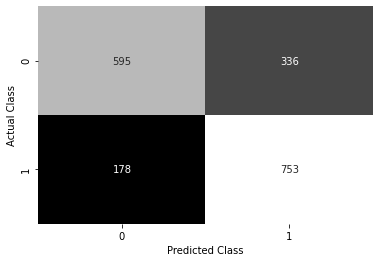

Accuracy Metrics:                 0
count  128.000000
mean     0.726115
std      0.033601
min      0.500756
25%      0.725777
50%      0.734089
75%      0.741058
max      0.754156

Loss Metrics:                 0
count  128.000000
mean     0.542924
std      0.033951
min      0.506976
25%      0.522973
50%      0.535389
75%      0.546829
max      0.693131

Val. Accuracy Metrics:                 0
count  128.000000
mean     0.708729
std      0.024601
min      0.490934
25%      0.706179
50%      0.714909
75%      0.719275
max      0.728677

Val. Loss Metrics:                 0
count  128.000000
mean     0.566425
std      0.025534
min      0.549776
25%      0.554095
50%      0.557649
75%      0.566313
max      0.693053


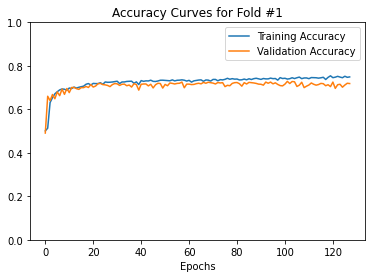

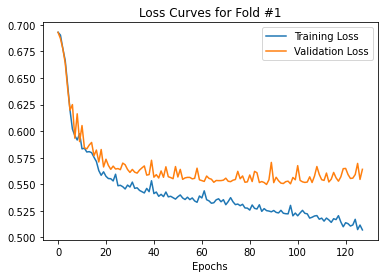

Training for Fold #2
Epoch 1/2500
47/47 [==============================] - 18s 221ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 2/2500
47/47 [==============================] - 7s 144ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 3/2500
47/47 [==============================] - 7s 144ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 4/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 5/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 6/2500
47/47 [==============================] - 7s 145ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 7/2500
47/47 [==============================] - 7s 144ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 

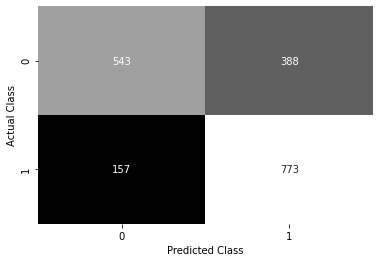

Accuracy Metrics:                 0
count  138.000000
mean     0.694300
std      0.079445
min      0.493620
25%      0.704919
50%      0.726494
75%      0.737534
max      0.754533

Loss Metrics:                 0
count  138.000000
mean     0.570044
std      0.059000
min      0.508998
25%      0.530118
50%      0.546093
75%      0.581279
max      0.693163

Val. Accuracy Metrics:                 0
count  138.000000
mean     0.677446
std      0.074278
min      0.490934
25%      0.686367
50%      0.707858
75%      0.716420
max      0.725991

Val. Loss Metrics:                 0
count  138.000000
mean     0.589013
std      0.047819
min      0.552319
25%      0.558434
50%      0.565577
75%      0.588537
max      0.693189


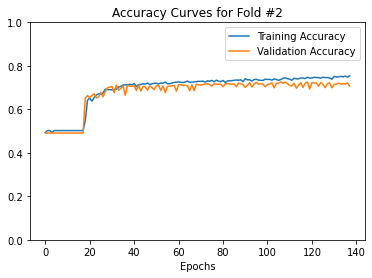

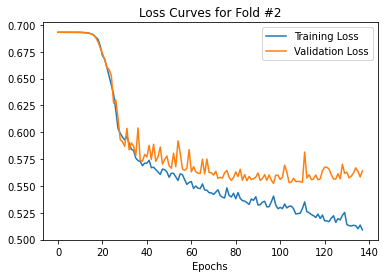

Training for Fold #3
Epoch 1/2500
47/47 [==============================] - 16s 180ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5091
Epoch 2/2500
47/47 [==============================] - 7s 147ms/step - loss: 0.6931 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 3/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6932 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 4/2500
47/47 [==============================] - 7s 148ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 5/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 6/2500
47/47 [==============================] - 7s 145ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 7/2500
47/47 [==============================] - 7s 145ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 

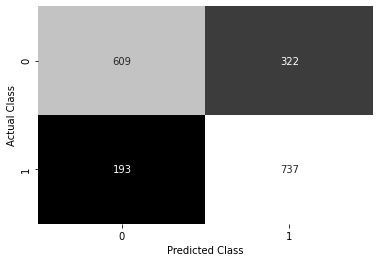

Accuracy Metrics:                 0
count  167.000000
mean     0.682237
std      0.092655
min      0.488919
25%      0.684268
50%      0.727334
75%      0.739171
max      0.756044

Loss Metrics:                 0
count  167.000000
mean     0.572945
std      0.067792
min      0.503423
25%      0.524537
50%      0.540418
75%      0.601849
max      0.693154

Val. Accuracy Metrics:                 0
count  167.000000
mean     0.671093
std      0.091411
min      0.490934
25%      0.677300
50%      0.717932
75%      0.727334
max      0.737408

Val. Loss Metrics:                 0
count  167.000000
mean     0.589550
std      0.057289
min      0.544057
25%      0.549100
50%      0.559917
75%      0.616767
max      0.693216


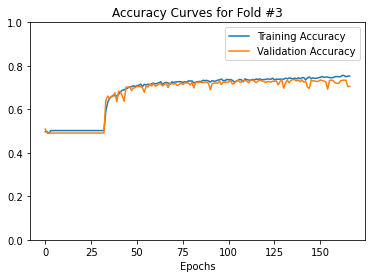

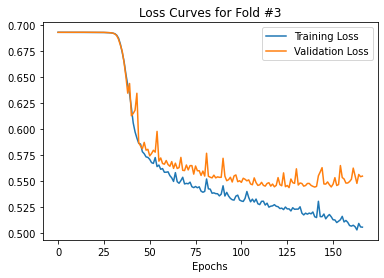

Training for Fold #4
Epoch 1/2500
47/47 [==============================] - 16s 178ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 2/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 3/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 4/2500
47/47 [==============================] - 7s 147ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 5/2500
47/47 [==============================] - 7s 147ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 6/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4909
Epoch 7/2500
47/47 [==============================] - 7s 145ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 

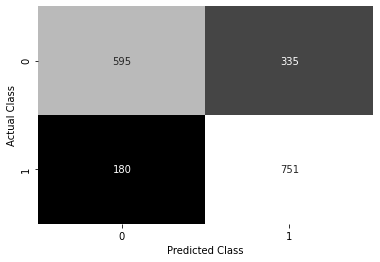

Accuracy Metrics:                 0
count  159.000000
mean     0.674757
std      0.093191
min      0.502183
25%      0.605692
50%      0.726158
75%      0.735309
max      0.757052

Loss Metrics:                 0
count  159.000000
mean     0.576379
std      0.070781
min      0.487363
25%      0.525184
50%      0.542665
75%      0.653924
max      0.693169

Val. Accuracy Metrics:                 0
count  159.000000
mean     0.653324
std      0.086908
min      0.490934
25%      0.598724
50%      0.700470
75%      0.708865
max      0.720618

Val. Loss Metrics:                 0
count  159.000000
mean     0.600330
std      0.054851
min      0.554939
25%      0.561161
50%      0.570478
75%      0.667038
max      0.693205


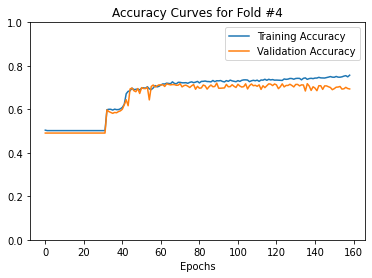

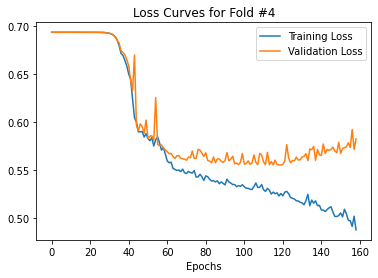

Training for Fold #5
Epoch 1/2500
47/47 [==============================] - 16s 179ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.4943
Epoch 2/2500
47/47 [==============================] - 7s 145ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.4943
Epoch 3/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4943
Epoch 4/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4943
Epoch 5/2500
47/47 [==============================] - 7s 147ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4943
Epoch 6/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4943
Epoch 7/2500
47/47 [==============================] - 7s 146ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 

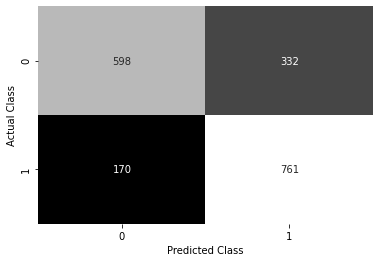

Accuracy Metrics:                 0
count  157.000000
mean     0.660555
std      0.098710
min      0.498489
25%      0.501343
50%      0.716085
75%      0.731867
max      0.750672

Loss Metrics:                 0
count  157.000000
mean     0.591611
std      0.069557
min      0.505927
25%      0.534965
50%      0.556373
75%      0.692188
max      0.693156

Val. Accuracy Metrics:                 0
count  157.000000
mean     0.655050
std      0.098475
min      0.494291
25%      0.494291
50%      0.713902
75%      0.723976
max      0.734721

Val. Loss Metrics:                 0
count  157.000000
mean     0.597401
std      0.064514
min      0.538976
25%      0.545670
50%      0.554934
75%      0.692228
max      0.693181


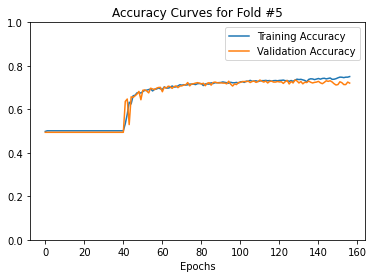

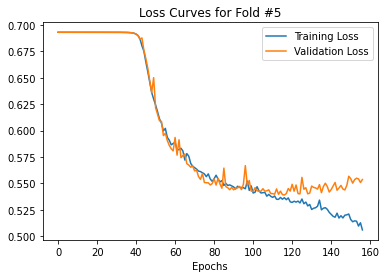

In [4]:
# Hyperparameters
epochs = 2500
batch_size = 128
validation_split = 0.2
lr = 1e-4
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=40, restore_best_weights=True)
opt = keras.optimizers.Adam(learning_rate=lr)

total_confmat = np.zeros((2, 2))
fold_num = 1
total_history = []
total_results = []

start = time.time()
for train, test in skfold.split(X, Y):
    X_train, X_test = X[train], X[test]
    Y_train = to_categorical(Y[train])
    Y_test = to_categorical(Y[test])

    keras.backend.clear_session()
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.set_weights(init_weights)
    model.reset_states()

    print(f'Training for Fold #{fold_num}')
    history = model.fit(X_train, Y_train, validation_split=validation_split,
                        epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])
    res = model.evaluate(X_test, Y_test)

    total_history.append(history)
    total_results.append(res)

    # Prediction
    Ypred = model.predict(X_test)
    Ypred = np.round(Ypred)
    print(classification_report(Y_test, Ypred))

    # Confusion Matrix
    confmat = confusion_matrix(Y_test.argmax(axis=1), Ypred.argmax(axis=1))
    confmat_heatmap = sns.heatmap(
        confmat, annot=True, fmt='', cmap='gray', cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('')
    plt.show()

    total_confmat += confmat

    # Stats of Metrics
    acc = pd.DataFrame(history.history['accuracy'])
    loss = pd.DataFrame(history.history['loss'])
    valacc = pd.DataFrame(history.history['val_accuracy'])
    valloss = pd.DataFrame(history.history['val_loss'])
    print(f'Accuracy Metrics: {acc.describe()}\n')
    print(f'Loss Metrics: {loss.describe()}\n')
    print(f'Val. Accuracy Metrics: {valacc.describe()}\n')
    print(f'Val. Loss Metrics: {valloss.describe()}')

    # Plots
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epochs')
    plt.title(label=f'Accuracy Curves for Fold #{fold_num}')
    plt.ylim(0, 1)
    plt.show()
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.title(label=f'Loss Curves for Fold #{fold_num}')
    plt.show()

    fold_num += 1

end = time.time()


In [5]:
np.mean(np.array(total_results)[:, 1]), np.std(np.array(total_results)[:, 1])


(0.7215772271156311, 0.007679265298192493)

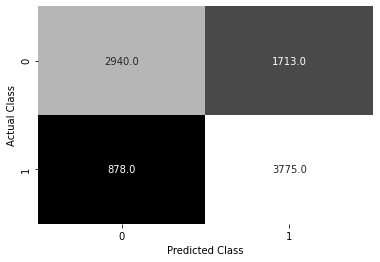

In [6]:
confmat_heatmap = sns.heatmap(
    total_confmat, annot=True, fmt='', cmap='gray', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('')
plt.show()


In [7]:
total_results


[[0.5481985211372375, 0.7239527106285095],
 [0.555158793926239, 0.7071467041969299],
 [0.5441509485244751, 0.7232670783996582],
 [0.5480913519859314, 0.7232670783996582],
 [0.5364534258842468, 0.7302525639533997]]